In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import shutil

from sklearn.preprocessing import MinMaxScaler

from tqdm.notebook import tqdm

In [3]:
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin

In [4]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda:0")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## Air Passenger with vanilla RNN and LSTM

In [6]:
from u8timeseries import TimeSeries
from u8timeseries.utils import TimeSeriesDataset
from u8timeseries import VanillaRNN, LSTM, RNNModel

In [7]:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

In [9]:
def training_split(data: TimeSeries, test_ts: pd.Timestamp, val_ts: pd.Timestamp = None) -> [TimeSeries]:
    """
    in order: test, [val,] train
    """
    split_series = []
    assert data.in_range_index(test_ts), "The splitting time stamp is outside the time range"
    train, test = data.split_after(test_ts)
    split_series.append(test)
    if val_ts is not None:
        assert train.in_range_index(val_ts), "The splitting time stamp is outside the training time range"
        train, val = train.split_after(val_ts)
        split_series.append(val)
    split_series.append(train)
    return split_series

In [10]:
# Number of features/channels used as input.
INPUT_SIZE = 1
# Number of previous time stamps taken into account.
SEQ_LENGTH = 12 # 132
# Number of features in last hidden state
HIDDEN_SIZE = 25
# number of output time-steps to predict
OUTPUT_SIZE = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

In [11]:
test, train = training_split(series, pd.Timestamp('19580801'))

In [46]:
my_model = RNNModel('RNN', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                    batch_size=32, n_epochs=2000, exp_name='Air_RNN', vis_tb=True)

In [47]:
my_model.set_optimizer(torch.optim.Adam, learning_rate=1e-2)
my_model.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=0.99)

In [48]:
my_model.set_val_series(test)

In [49]:
my_model.fit(train)  # 107

<Loss>: 0.0022 Loss: 0.0265


Result of training

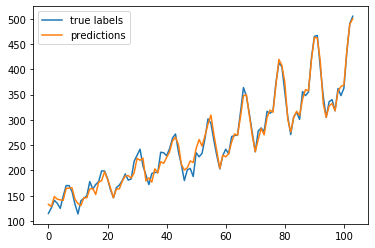

MSE: 118.738197


In [50]:
my_model.plot_result_train()

Test with horizon=1

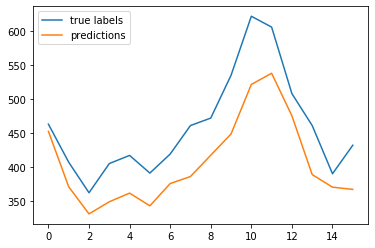

MSE: 3412.324951


In [51]:
my_model.test_series(test)

Test with horizon=28

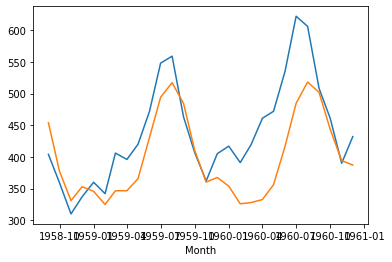

In [52]:
pred_series = my_model.predict(28)
test.plot()
pred_series.plot()

#### LSTM

In [53]:
my_model_lstm = RNNModel('LSTM', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                         batch_size=32, n_epochs=1000, exp_name='Air_LSTM', vis_tb=True)

In [54]:
my_model_lstm.set_optimizer(torch.optim.Adam, learning_rate=1e-2)
my_model_lstm.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=1.)

In [55]:
my_model_lstm.set_val_series(test)

In [56]:
my_model_lstm.fit(train)  # 107

<Loss>: 0.0005 Loss: 0.0221


In [66]:
my_model_lstm = RNNModel('LSTM', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                         batch_size=32, n_epochs=2000, exp_name='Air_LSTM', vis_tb=True)

In [67]:
my_model_lstm.set_optimizer(torch.optim.Adam, learning_rate=1e-2)
my_model_lstm.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=1.)

In [68]:
my_model_lstm.set_val_series(test)

In [60]:
my_model_lstm.load_from_checkpoint(is_best=False)

=> loading checkpoint 'checkpoint_999.pth.tar'
=> loaded checkpoint 'checkpoint_999.pth.tar' (epoch 1000)


In [61]:
my_model_lstm.fit(train)  # 107

<Loss>: 0.0001 Loss: 0.0240


Result of training

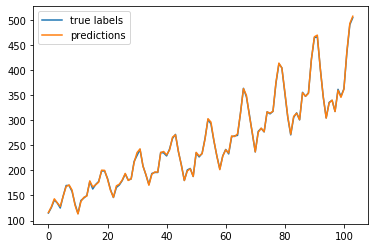

MSE: 2.854207


In [62]:
my_model_lstm.plot_result_train()

Test with horizon=1

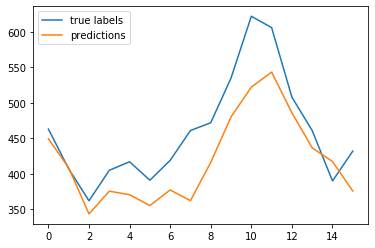

MSE: 2582.275391


In [63]:
my_model_lstm.test_series(test)

Test with horizon=28

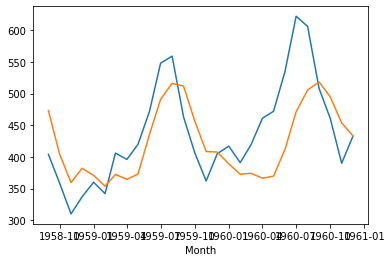

In [75]:
pred_series = my_model_lstm.predict(28)
test.plot()
pred_series.plot()

In [74]:
my_model_lstm.set_train_dataset(train)

=> loading checkpoint 'model_best_1190.pth.tar'
=> loaded checkpoint 'model_best_1190.pth.tar' (epoch 1191)


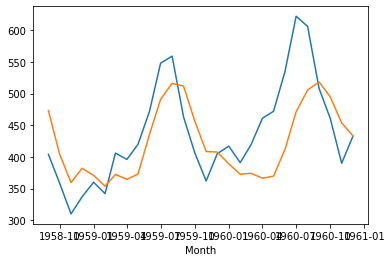

In [76]:
pred_series = my_model_lstm.predict(28, is_best=True)
test.plot()
pred_series.plot()

## monthly sunspot

In [77]:
df2 = pd.read_csv('monthly-sunspots.csv', delimiter=",")
series2 = TimeSeries.from_dataframe(df2, 'Month', 'Sunspots')

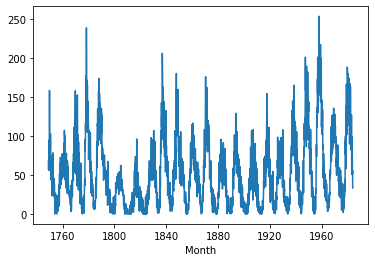

In [78]:
series2[:].plot()

In [120]:
from u8timeseries.models.statistics import check_seasonality, plot_acf

In [106]:
check_seasonality(series2, max_lag=240)

(True, 125)

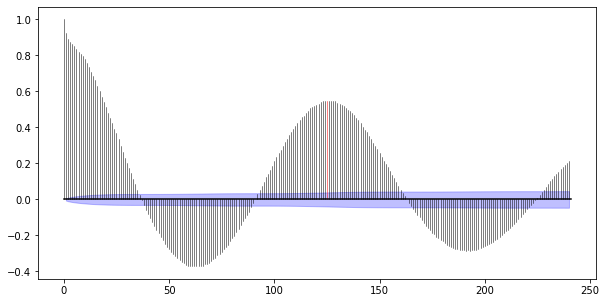

In [104]:
plot_acf(series2, 125, max_lag=240)

In [79]:
test, train = training_split(series2, pd.Timestamp('19200801'))

In [108]:
INPUT_SIZE = 1
SEQ_LENGTH = 125
HIDDEN_SIZE = 10
OUTPUT_SIZE = 1
NUM_LAYERS = 2

In [170]:
my_model_sun = RNNModel('LSTM', INPUT_SIZE, OUTPUT_SIZE, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS,
                        batch_size=64, n_epochs=800, exp_name='sun_LSTM', vis_tb=True)

In [171]:
my_model_sun.set_optimizer(torch.optim.Adam, learning_rate=1e-4)
my_model_sun.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=0.995)

In [172]:
my_model_sun.set_val_series(test)

In [173]:
my_model_sun.fit(train)  # 107

<Loss>: 0.0127 Validation Loss: 0.0137


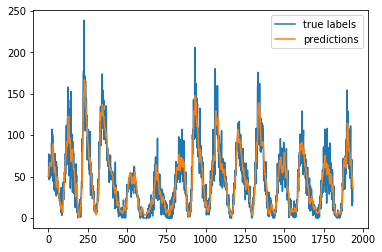

MSE: 241.481506


In [174]:
my_model_sun.plot_result_train()

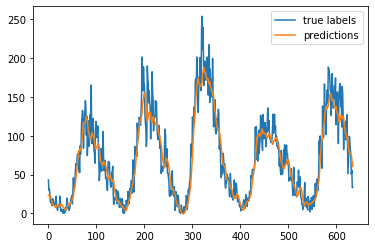

MSE: 362.990906


In [175]:
my_model_sun.test_series(test)

=> loading checkpoint 'model_best_640.pth.tar'
=> loaded checkpoint 'model_best_640.pth.tar' (epoch 641)


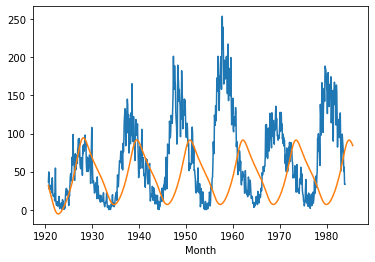

In [176]:
pred_series = my_model_sun.predict(780, is_best=True)
test.plot()
pred_series.plot()

#### remove seasonal component

In [131]:
from u8timeseries.models.statistics import extract_trend_and_seasonality, remove_seasonality, remove_from_series

In [154]:
trend, season = extract_trend_and_seasonality(series2, 125, 'add')

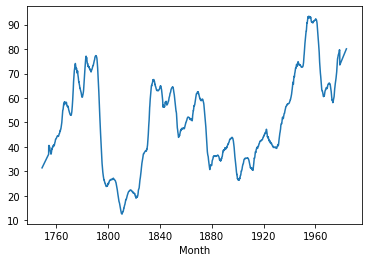

In [155]:
trend.plot()

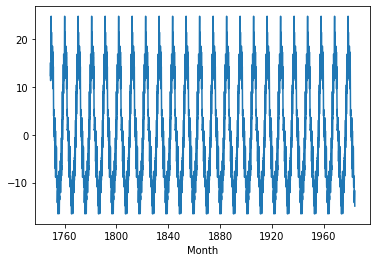

In [156]:
season.plot()

In [157]:
series3 = remove_from_series(series2, season, 'add')
noise = remove_from_series(series3, trend, 'add')

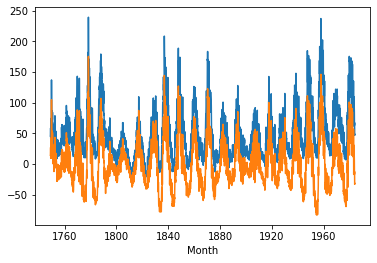

In [158]:
series3.plot()
noise.plot()